In [23]:
import os
import cv2
import torch
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from models.autoencoders import VAE
from utils_.utils import from_sim_get_poses_n_gripper
from utils_.plotting import plot_waypoints_and_initial_image
from utils_.waypoint_extraction import pickplace_task_waypoints

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")
DATA_PATH = "./datasets/sim_recs"
IMAGE_RESIZE = 256
LATENT_DIM = 16
DATAPOINT_COUNT = -1
AE_PATH = "./logs/models/VAE_2024-10-25_16:30/pth/epoch_400.pth"
L2W_PATH = "./logs/models/mlp_2024-10-21_16:47/pth/epoch_2000.pth"
dirs = os.listdir(DATA_PATH)
im_paths = [f"{DATA_PATH}/{dir}/images/0000.jpg" for dir in dirs]

Device Name: NVIDIA GeForce RTX 3090


In [ ]:
image_encoder = VAE(latent_dim=LATENT_DIM).to(device=device)
image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))

# # Create the input data: latent representation of initial scene images
# X = []
# for i, im_path in tqdm(enumerate(im_paths)):
#     image = cv2.imread(im_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (IMAGE_RESIZE, IMAGE_RESIZE))
#     image = image/255.0
#     image = np.transpose(image, (2, 0, 1))  # HWC to CHW
#     latent, _ = image_encoder.encode(torch.Tensor(np.array([image])).to(device))
#     X.append(latent[0].cpu().detach().numpy())
#     if i == DATAPOINT_COUNT-1:
#         break

# X = np.array(X)
# np.save('./datasets/latent_to_waypoints/X.npy', X)
X = np.load('./datasets/latent_to_waypoints/X.npy')[:200]
print(X.shape)

(200, 16)


/tmp/ipykernel_4133/3727086397.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_encoder.load_state_dict(torch.load(AE_PATH, map_location=device))


In [26]:
# # Create output data: waypoint collections from the paths
# ways = []
# for i, ep_path in tqdm(enumerate(dirs)):
#     pos, quat, gripper_widths = from_sim_get_poses_n_gripper(f"{DATA_PATH}/{ep_path}/proprioceptives.txt")
#     ways.append(pickplace_task_waypoints(pos, gripper_widths))
#     if i == DATAPOINT_COUNT-1:
#         break
# ways = np.array(ways)

# y = ways.reshape(ways.shape[0], -1)
# del ways
# np.save('./datasets/latent_to_waypoints/y.npy', y)
y = np.load('./datasets/latent_to_waypoints/y.npy')[:200]
print(y.shape)

(200, 9)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = .5, learning_rate = 1e-1,
                          max_depth = 50, n_estimators = 100, alpha=.0,
                            subsample=1,
                            gamma=0.001,
                            min_child_weight=10)

xg_reg.fit(X_train, y_train)

for i in range(2):
    if i:
        y_pred = xg_reg.predict(X_test)
        errors = y_test - y_pred
    else:
        y_pred = xg_reg.predict(X_train)
        errors = y_train - y_pred
    
    errors = errors[:, :2]
    errors = [np.linalg.norm(e) for e in errors]
    mean_error = sum(errors)/len(errors)
    devs = [abs(e-mean_error) for e in errors]
    dev_error = sum(devs)/len(devs)

    if i:
        print("Test avg. dist. from desired point (m): ", mean_error)
        print("Test avg. dev. from desired point (m): ", dev_error)
    else:
        print("Train avg. dist. from desired point (m): ", mean_error)
        print("Train avg. dev. from desired point (m): ", dev_error)
    print("+--------------------------------------------------------------+")

Train avg. dist. from desired point (m):  0.016847383033668263
Train avg. dev. from desired point (m):  0.009111291190421648
+--------------------------------------------------------------+
Test avg. dist. from desired point (m):  0.052929921293692936
Test avg. dev. from desired point (m):  0.03260224542752791
+--------------------------------------------------------------+


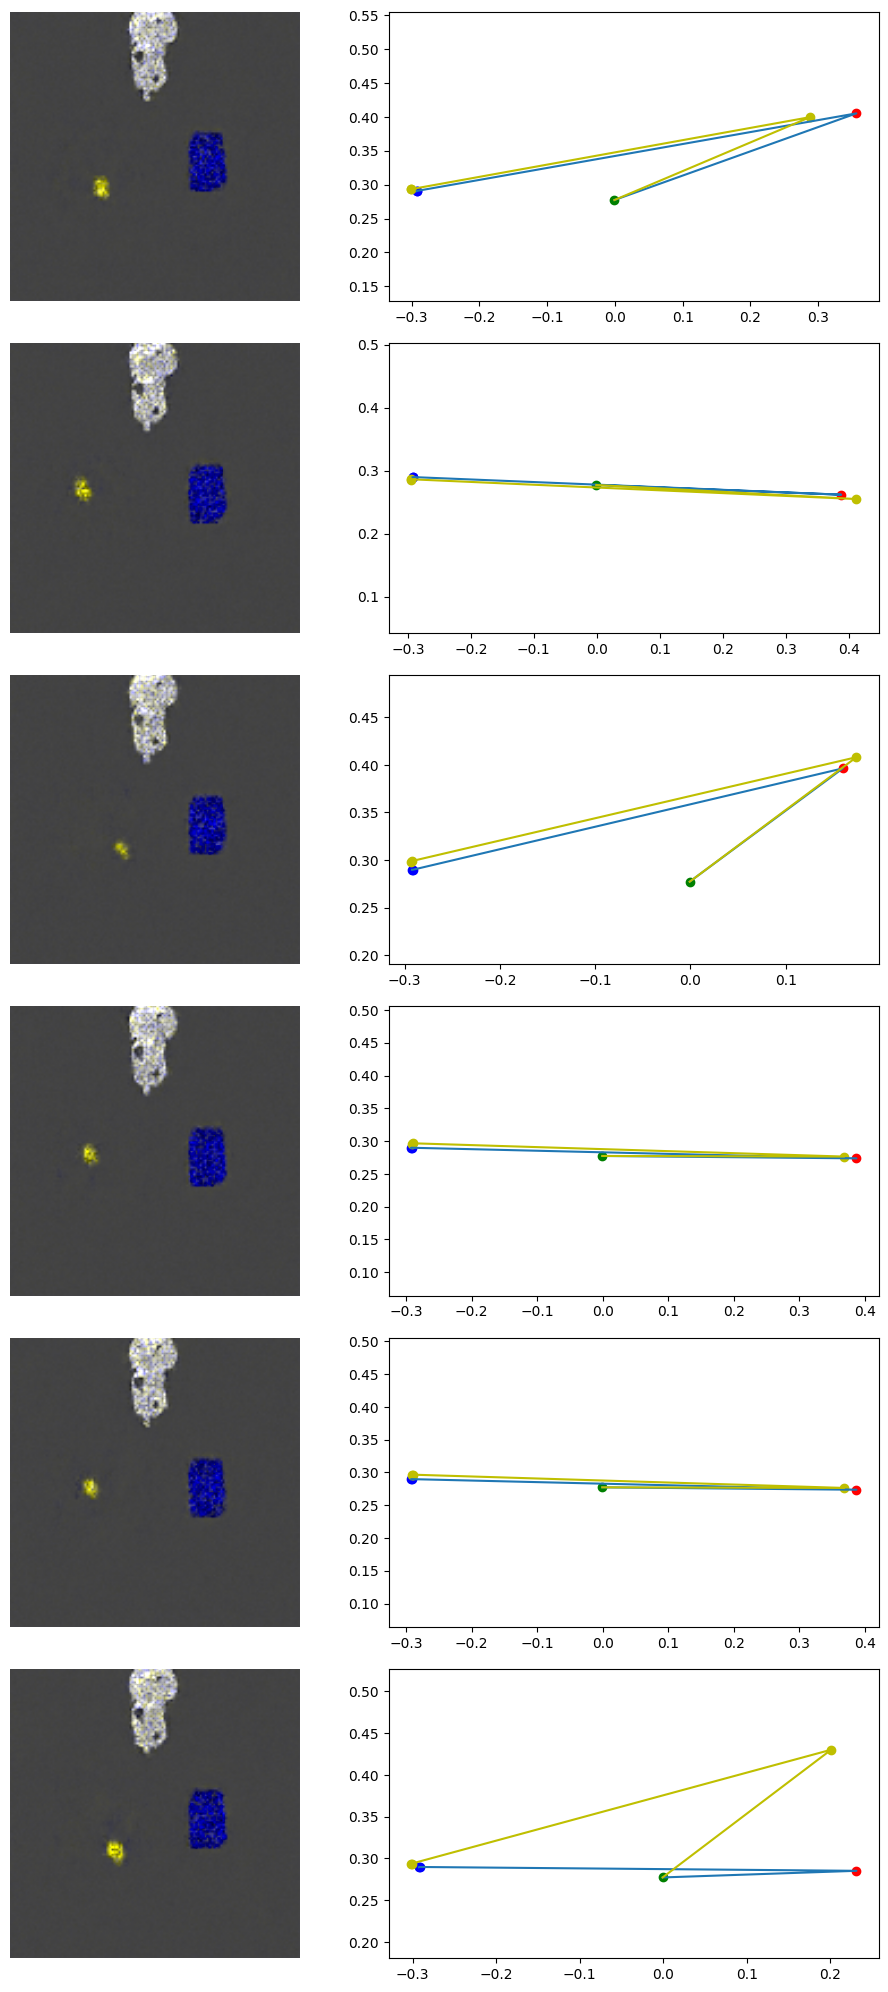

In [28]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

latent = X_test[rand_indices]
imgs = image_encoder.decode(torch.Tensor(latent).to(device))
imgs = imgs.detach().cpu().numpy()
imgs = np.maximum(imgs, 0)
imgs = np.minimum(imgs, 1)
imgs = np.transpose(imgs, (0, 2, 3, 1))

target_waypoints = y_test[rand_indices].reshape(6, 3, 3)

pred_waypoints =  xg_reg.predict(latent)
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs)